# ESN predictions on MJO without TDE

In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


In [3]:
header = ["year", "month", "day", "hour", "PC1 coeff", "PC2 coeff", "PC1+PC2 amplitude"]
data = CSV.read("data/mjo_data/mjo_romi.txt", DataFrame; delim=" ", ignorerepeated=true, header=header);

pc1 = data[!,"PC1 coeff"]
pc2 = data[!,"PC2 coeff"]
amp = data[!, "PC1+PC2 amplitude"];

In [8]:
train_size= Int(floor(size(Ds,2) * 0.8))
test_size = 100
val_size= size(Ds,2) - train_size - test_size;

## train ESNs

In [25]:
data= Matrix(transpose([pc1 pc2]))

2×12603 Matrix{Float64}:
  0.12526   0.18542   0.2396   0.27446  …  -0.40529  -0.33531  -0.37026
 -0.06945  -0.04887  -0.03933  0.0199      -0.40887  -0.38871  -0.34477

In [28]:
pc1_train = data[1:1, 1:train_size]
pc1_val = data[1:1, train_size+1:train_size+val_size]
pc1_test = data[1:1, train_size+val_size+1:train_size+val_size+test_size];

pc2_train = data[2:2, 1:train_size]
pc2_val = data[2:2, train_size+1:train_size+val_size]
pc2_test = data[2:2, train_size+val_size+1:train_size+val_size+test_size];

In [29]:
spectral_radii = [0.8,0.9,1.0]
sparsities = [0.14,0.1,0.5]
input_scales = [0.1,1.0]
ridge_values = [0.0,1e-5, 1e-6]
reservoir_sizes = [500,700,1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)

esn_pc1, W_out_pc1, val_loss_pc1 = enso_project.cross_validate_esn(pc1_train, pc1_val, param_grid)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 2058.2749527989154
enso_project.ESNHyperparams(500, 0.9, 0.14, 0.1, 0.0)
Validation loss = 2057.049338613077
enso_project.ESNHyperparams(1000, 0.9, 0.14, 0.1, 0.0)
Validation loss = 2055.2013736341696
enso_project.ESNHyperparams(500, 0.9, 0.1, 0.1, 0.0)
Validation loss = 2048.8162154813417
enso_project.ESNHyperparams(1000, 0.9, 0.1, 0.1, 0.0)
Validation loss = 2048.5017375560315
enso_project.ESNHyperparams(500, 1.0, 0.1, 0.1, 1.0e-5)
Validation loss = 2042.1188530517852


(ESN(1 => 500), OutputLayer successfully trained with output size: 1, 2042.1188530517852)

In [30]:
spectral_radii = [0.8,0.9,1.0]
sparsities = [0.14,0.1,0.5]
input_scales = [0.1,1.0]
ridge_values = [0.0,1e-5, 1e-6]
reservoir_sizes = [500,700,1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)

esn_pc2, W_out_pc2, val_loss_pc2 = enso_project.cross_validate_esn(pc2_train, pc2_val, param_grid)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1739.5666444141311
enso_project.ESNHyperparams(1000, 0.8, 0.14, 0.1, 0.0)
Validation loss = 1736.0849884351494
enso_project.ESNHyperparams(500, 0.8, 0.1, 0.1, 0.0)
Validation loss = 1731.6362950857554
enso_project.ESNHyperparams(700, 0.9, 0.1, 0.1, 0.0)
Validation loss = 1730.852170979088
enso_project.ESNHyperparams(500, 1.0, 0.1, 0.1, 0.0)
Validation loss = 1724.4617543810198
enso_project.ESNHyperparams(1000, 0.8, 0.1, 1.0, 0.0)
Validation loss = 1674.5887087731526


(ESN(1 => 1000), OutputLayer successfully trained with output size: 1, 1674.5887087731526)

## evaluate predictions

In [31]:
prediction_D1 = enso_project.esn_eval_pred(esn_pc1, W_out_pc1, pc1_test)
prediction_D2 = enso_project.esn_eval_pred(esn_pc2, W_out_pc2, pc2_test);

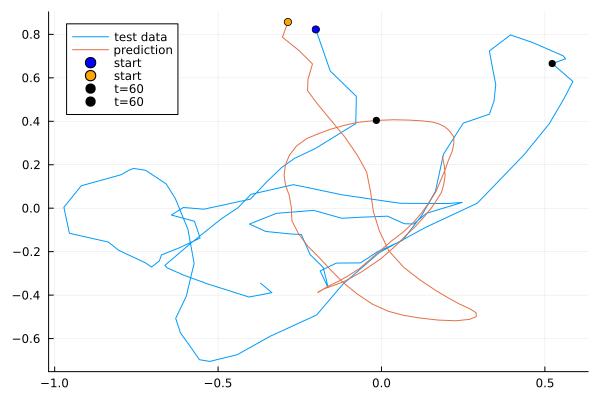

In [33]:
plot(pc1_test[1,:], pc2_test[1,:], label="test data")
plot!(prediction_D1, prediction_D2, label="prediction")
scatter!([pc1_test[1,1]], [pc2_test[1,1]], label="start", color=:blue, marker=:circle, markersize=4)
scatter!([prediction_D1[1]], [prediction_D2[1]], label="start", color=:orange, marker=:circle, markersize=4)
scatter!([pc1_test[1,50]], [pc2_test[1,50]], label="t=60", color=:black, marker=:circle, markersize=4)
scatter!([prediction_D1[50]], [prediction_D2[50]], label="t=60", color=:black, marker=:circle, markersize=4)